In [111]:
# allow for imports from ../src directory

from os import path as os_path
from os import getcwd
from sys import path as sys_path

sys_path.append(os_path.dirname(getcwd())) 

In [112]:
from dataclasses import dataclass
from dacite import from_dict

import scipy.optimize as optim
import numpy as np
import pandas as pd
import siunits as unit

from scipy import interpolate
from scipy.integrate import trapezoid
from scipy.constants import epsilon_0, elementary_charge, Boltzmann, Avogadro
from src.helper_functions import read_render_markdown_file
from src.plotting import make_simple_plot, fast_plot

### Physical constants

1. the electric constant (vacuum permittivity) $\epsilon_0$. Units:  $\textstyle{\rm s^{4}\cdot A^{2}\cdot kg^{-1}\cdot m^{-3}}$ or $\textstyle{\rm C^2 \cdot N^{−1} \cdot m^{−2}}$ or $\textstyle{\rm C \cdot V^{−1} \cdot m^{−1}}$ 

In [113]:
unit.epsilon_0

ampere²·second⁴·meter⁻³·kilogram⁻¹ (A²·s⁴·m⁻³·kg⁻¹), [kg: -1, s: 4, A: 2, m: -3]

In [114]:
epsilon_0

8.8541878128e-12

2. Elementary charge (charge on electron). Units: $\rm C$

In [115]:
unit.c

coulomb (C), [s: 1, A: 1]

In [116]:
elementary_charge

1.602176634e-19

3. Boltzmann constant. Units: $\rm m^2 \cdot kg \cdot s^{-2} \cdot {K}^{-1}$

In [117]:
Boltzmann

1.380649e-23

4. Avogadro's number. Units: $\rm mol^{-1}$

In [8]:
Avogadro

6.02214076e+23

### Singlet model parameters

See Page 62

Dictionary of model parameters

In [9]:
fluid = "kcl"

In [10]:
parameters = dict({"kcl": dict({"component": ["K", "Cl"], "valence": np.array([
                  1.0, -1.0]), "temperature": 1075.0, "concentration": np.array([19.265, 19.265]),
                  "epsilon_r": 1.0})})

        #parameters = dict({"name": "H_2O", "component": ["H", "O"], "valence": np.array([
        #                1.0, -1.0]), "temperature": 298.0, "concentration": np.array([1.0, 1.0]),
        #    "epsilon_r": 1.0})


In [11]:
@dataclass
class Fluid:
    name: str
    component: list[str]
    valence: np.ndarray
    temperature: float
    concentration: np.ndarray
    epsilon_r: float
    n_component: int
    n_pair: int

In [12]:
def set_fluid_parameters(name):
    name = name.lower()
    model_params = parameters[name]
    model_params["name"] = name
    n_component = model_params["n_component"] = len(model_params["component"])
    model_params["n_pair"] = int((n_component+1) * (n_component) / 2)
    return from_dict(data_class=Fluid, data=model_params)

In [13]:
fluid = set_fluid_parameters("kcl")

In [14]:
fluid

Fluid(name='kcl', component=['K', 'Cl'], valence=array([ 1., -1.]), temperature=1075.0, concentration=array([19.265, 19.265]), epsilon_r=1.0, n_component=2, n_pair=3)

Numerical discretisation

In [15]:
z_cutoff = 50.0    # from UI
n_point = 2001     # from UI
grid_size = z_cutoff / (n_point - 1) 
z = np.linspace(0.0, z_cutoff, n_point)
z_indices = np.arange(0, n_point, dtype=int)

$\beta = 1 / k T$. Units: $\rm m^{-2} \cdot kg^{-1} \cdot s^{2}$

In [104]:
beta = 1.0 / (Boltzmann * fluid.temperature)

In [106]:
beta

6.737646991665042e+19

In [107]:
epsilon = 4.0 * np.pi * fluid.epsilon_r * epsilon_0  # units same as $\epsilon_0$ (allow for distances in angstrom)

In [108]:
epsilon

1.1126500554478704e-10

In [129]:
dist = 10 / 1e10

In [130]:
denominator = (epsilon * dist)

In [132]:
denominator

1.1126500554478705e-19

In [133]:
beta * elementary_charge * elementary_charge / denominator

15.544274130073246

In [19]:
valence = fluid.valence
concentration = fluid.concentration
n_pair = fluid.n_pair
n_component = fluid.n_component

Model potential KCl

In [20]:
read_render_markdown_file("../docs/equation_4_1.md")
read_render_markdown_file("../docs/equation_4_2.md")
read_render_markdown_file("../docs/equation_4_3.md")

$$ u_{ij}(r) = \frac{q_i q_j}{\varepsilon r} + B_{ij} \exp(-\alpha r) + \frac{C_ij}{r^6} + \frac{D_{ij}}{r^8} $$

$$ B_{ij} = \beta_{ij} \, b \exp[\alpha(\sigma_i + \sigma_j)] $$

$$ \beta_{ij} = 1 + \frac{Z_i}{n_i} + \frac{Z_j}{n_j} $$

In [21]:
n_outer_shell = np.array([8., 8.])

In [22]:
def calc_l_index(i, j):
    return i + j    

In [23]:
def calc_beta_pauling(valence, n_outer_shell):
    beta_pauling = np.zeros(n_pair)
    for i in range(n_component):
        for j in range(i, n_component):
            l = calc_l_index(i, j)
            beta_pauling[l] = 1.0 + valence[i] / n_outer_shell[i] + valence[j] / n_outer_shell[j]
    return beta_pauling

In [24]:
beta_pauling = calc_beta_pauling(fluid.valence, n_outer_shell)

In [25]:
beta_pauling

array([1.25, 1.  , 0.75])

In [26]:
alpha = 1.0 / 0.337
b = 0.338e-19
sigma = [1.463, 1.585]

cap_c = np.array([24.3, 48.0, 124.5]) * 1e-19
cap_d = np.array([24.0, 73.0, 250.0]) * 1e-19

In [166]:
def calc_cap_b(beta_pauling, b, alpha, sigma):
    cap_b = np.zeros(n_pair)
    for i in range(n_component):
        for j in range(i, n_component):
            l = calc_l_index(i, j)
            cap_b[l] = beta_pauling[l] * b * np.exp(alpha * (sigma[i] + sigma[j]))
    return cap_b

In [167]:
cap_b = calc_cap_b(beta_pauling, b, alpha, sigma)

In [169]:
beta * cap_b

array([16791.65813278, 19293.2728126 , 20782.10350479])

In [30]:
#TODO: Fix up choice of c(r) / c*(r) and make sure discretisation matches
# Read in some c(r) -- currently LJ charged spheres

def load_cr():
    CR_PATH = "../pyOZ_bulk_fluid/tests/lj/nrcg-cr.dat.orig"
    cr_df = pd.read_csv(CR_PATH, header=None, delim_whitespace=True)
    cr_df.set_index(0, inplace=True)
    r = cr_df.index.to_numpy()
    cr = cr_df.to_numpy()
    return cr, r

In [31]:
cr_in, r_in = load_cr()

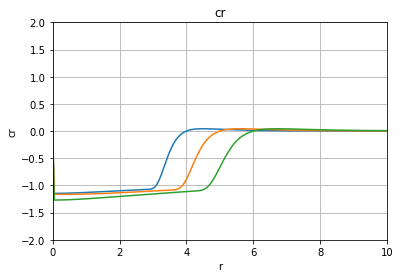

'cr'

In [32]:
make_simple_plot(r_in, cr_in, "r", "cr", "cr", yliml=[-2, 2])

In [33]:

def interpolate_cr(r_in, cr_in):
    cr = np.zeros((n_point, n_pair))
    for l in range(n_pair):
        f = interpolate.interp1d(r_in, cr_in[:, l])
        r = z
        cr[:, l] = f(r)
    return cr, r

In [34]:
cr, r = interpolate_cr(r_in, cr_in)

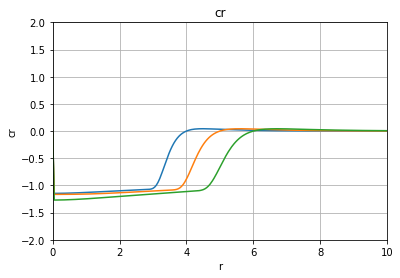

'cr'

In [35]:
make_simple_plot(r, cr, "r", "cr", "cr", yliml=[-2, 2])

In [36]:
def calc_charge(valence):
    return valence * elementary_charge

In [37]:
charge = calc_charge(valence)

In [141]:
r_m = r * 1e-10  # convert distance from Angstrom to m

In [170]:
# Use same discretisation for r as z [Confirm?]

def calc_u(valence, cap_b, alpha, cap_c, cap_d, r):
    u = np.zeros((n_point, n_pair))
    for i in range(n_component):
        for j in range(i, n_component):
            l = calc_l_index(i, j)
            u[1:, l] = (charge[i] * charge[j]) / (r_m[1:] * epsilon) + cap_c[l] / \
                r[1:]**6 + cap_d[l]/r[1:]**8 + \
                cap_b[l] * np.exp(-alpha * r[1:])
    return u


In [171]:
#TODO: Sort out units for this - doesn't make sense currently

u = calc_u(charge, cap_b, alpha, cap_c, cap_d, r)

In [172]:
beta * u

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.06041086e+15,  3.22470124e+15,  1.10423967e+16],
       [ 4.15008872e+12,  1.26120128e+13,  4.31746263e+13],
       ...,
       [ 3.11196680e+00, -3.11196677e+00,  3.11196685e+00],
       [ 3.11041004e+00, -3.11041001e+00,  3.11041008e+00],
       [ 3.10885484e+00, -3.10885481e+00,  3.10885488e+00]])

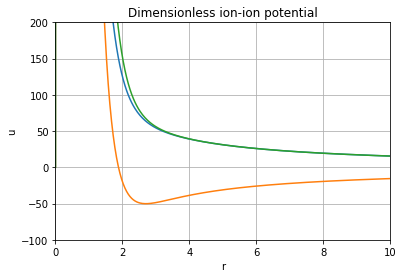

'Dimensionless ion-ion potential'

In [173]:
make_simple_plot(r, beta * u, "r", "u", "Dimensionless ion-ion potential", xliml=[0, 10], yliml=[-100, 200])

In [43]:
psi_0 = 100     # 100 mV  -- get from UI

rho ($\rho$) is the number density which we calculate from the concentration ($c$):

$\rho = c \, \rm mol \, dm^{-3} \cdot dm^{3} / 1.0 \cdot 10^{27} \cdot A^{3} \cdot N_{A} \, mol^{-1}$. Units: $\rm A^{-3}$


In [44]:
def calc_rho(concentration):
    return np.array(concentration) / 1.0e27 * Avogadro

In [45]:
rho = calc_rho(concentration)

In [46]:
rho   # values seem reasonable (compared with those in thesis)

array([0.01160165, 0.01160165])

In [47]:
charge = calc_charge(valence)

In [48]:
def calc_kappa(beta, rho, epsilon):
    return np.sqrt(4.0 * np.pi * beta / epsilon * 1e10 *
    sum(np.multiply(charge**2, rho)))


In [49]:
kappa = calc_kappa(beta, rho, epsilon)

In [50]:
kappa      # similar to thesis value (6.77) page 62 - maybe revisions to physical constants in past 25 years (e.g. 2019 change for $e$)

6.732325586635704

### Wall-ion soft-potential

In [51]:
phiw = np.zeros((n_point, n_component))
hw = np.zeros((n_point, n_component))
tw = np.zeros((n_point, n_component))
# int_0_z = np.zeros((n_point, n_component))
# int_z_inf = np.zeros((n_point, n_component))

In [52]:
# same for both ions

def calc_phiw(z, n_component):
    capital_a = 16.274e-19 # joules
    wall_d = 2.97  # inverse Angstrom
    for i in range(n_component):
        phiw[:, i] = np.exp(-wall_d * z) * capital_a * (wall_d * z + 2)
    return phiw


In [53]:
beta_phiw = beta * calc_phiw(z, n_component)

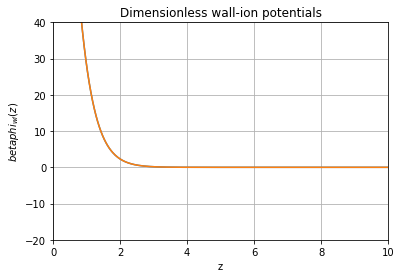

'Dimensionless wall-ion potentials'

In [54]:
make_simple_plot(z, beta_phiw, "z", "$beta phi_{wi}(z)$", "Dimensionless wall-ion potentials")

This dimensionless plot matches well with Figure 4.1(b) of thesis.

### Bulk fluid inputs

Not sure what to do here -- maybe run pyOZ for ionic fluid and try using c_{ij}(r) from this as an approximation?

In [55]:
read_render_markdown_file("../docs/equation_3_4.md")

$$ f_{ij}^{(n)}(z) = \int_z^{\infty} dr r^n c_{ij}^{*} $$

In [56]:
# Assume all of the moments of the short-ranged bulk direct correlation functions to be zero initially

f1 = np.zeros((n_point, n_pair))
f2 = np.zeros((n_point, n_pair))
c_short = np.zeros((n_point, n_pair))

In [57]:
# for now assume c*(r) = c(r)

c_short = cr

In [58]:
charge_pair = np.array([1, -1, 1]) * elementary_charge

In [59]:
read_render_markdown_file("../docs/equation_3_5.md")

$$ c_{ij}^*(r) = c_{ij}(r) + \beta q_i q_j / (\varepsilon r) $$

In [60]:
#TODO: Too big?

beta * charge_pair[0] / epsilon

97019728038.75784

In [61]:
c_short

array([[ 0.     ,  0.     ,  0.     ],
       [-0.57316, -0.58233, -0.63448],
       [-1.14632, -1.16466, -1.26896],
       ...,
       [ 0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ]])

In [62]:
# skip r = 0 to avoid divide by 0 error

#for l in range(n_pair):
#    c_short[1:, l] = c_short[1:, l]  + beta * charge_pair[l] * 1e-10 / (epsilon * r[1:])
    

In [63]:
c_short

array([[ 0.     ,  0.     ,  0.     ],
       [-0.57316, -0.58233, -0.63448],
       [-1.14632, -1.16466, -1.26896],
       ...,
       [ 0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ]])

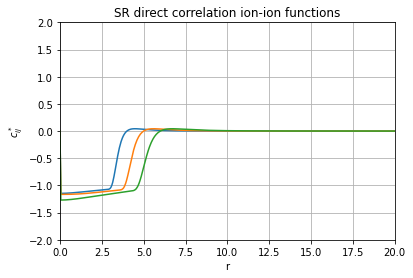

'SR direct correlation ion-ion functions'

In [64]:
make_simple_plot(r, c_short, "r", "$c_{ij}^*$", "SR direct correlation ion-ion functions", xliml=[0, 20], yliml=[-2, 2])

In [65]:
def int_z_infty_dr_r_c_short(c_short, z):
    for ij in range(n_pair):
        for k, _ in enumerate(z):
            f1[k, ij] = trapezoid(y=z[:k] * c_short[k, ij], x=z[:k])
    return f1

In [66]:
def int_z_infty_dr_r2_c_short(c_short, z):
    for ij in range(n_pair):
        for k, _ in enumerate(z):
            f2[k, ij] = trapezoid(y=z[:k] * z[:k] * c_short[k, ij], x=z[:k])
    return f2

In [67]:
f1 = int_z_infty_dr_r_c_short(c_short, z)

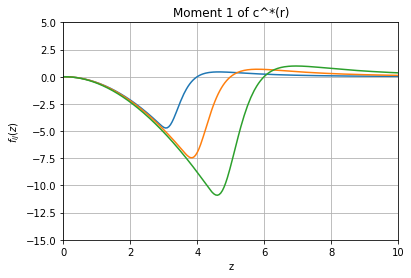

'Moment 1 of c^*(r)'

In [68]:
make_simple_plot(z, f1, "z", "$f_{ij}(z)$", "Moment 1 of c^*(r)", yliml=[-15, 5])

In [69]:
f2 = int_z_infty_dr_r2_c_short(c_short, z)

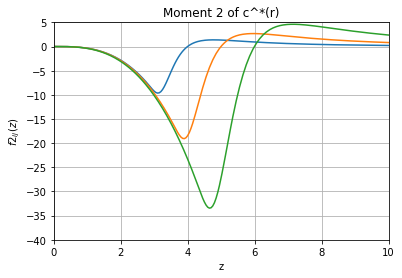

'Moment 2 of c^*(r)'

In [70]:
make_simple_plot(z, f2, "z", "$f2_{ij}(z)$", "Moment 2 of c^*(r)", yliml=[-40, 5])

Initial guess for solution $t_{wi}(z)$ - solving $F(t(z)) = 0$

In [71]:
tw_initial = np.zeros((n_point, n_component))    # initial guess of zero - maybe should be \beta \phi

# tw = beta_phiw_i

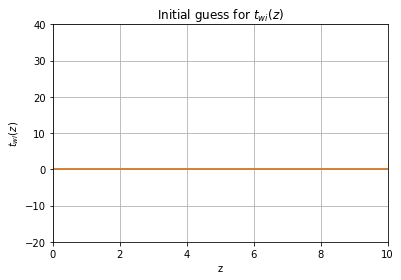

'Initial guess for $t_{wi}(z)$'

In [72]:
make_simple_plot(z, tw_initial, "z", "$t_{wi}(z)$", "Initial guess for $t_{wi}(z)$")

In [73]:
def calc_hw(tw, beta_phiw):
    for i in range(n_component):
        hw[:, i] = np.exp(tw[:, i] - beta_phiw[:, i]) - 1.0
    return hw


In [74]:
hw = calc_hw(tw_initial, beta_phiw)

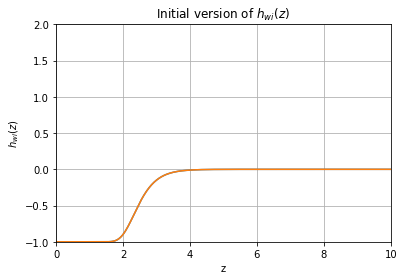

'Initial version of $h_{wi}(z)$'

In [75]:
make_simple_plot(z, hw, "z", "$h_{wi}(z)$", "Initial version of $h_{wi}(z)$", yliml=[-1, 2])

In [76]:
beta_psi =  beta * psi_0

In [77]:
beta_psi

6.737646991665042e+21

In [78]:
np.log(np.exp(beta_phiw))

array([[219.29693428, 219.29693428],
       [211.16274464, 211.16274464],
       [203.06973038, 203.06973038],
       ...,
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ]])

In [79]:
read_render_markdown_file("../docs/equation_5_9.md")
read_render_markdown_file("../docs/equation_5_9b.md")

$$ \large t_{wi}(z) = \ln \left[ g_{wi}(z) \exp(\beta \phi_{wi}(z)) \right] $$

$$ t_{wi}(z) ~=~ - \beta q_i \psi_0 + 2 \pi \sum_{j} \bar{\rho_j} \left \{  z f_{ij}^{(1)}(z) - f_{ij}^{(2)}(z) - \left( 2 \beta q_i q_j / \varepsilon \right ) \left(  \int_0^z dt t h_{wj}(t) + z \int_{z}^{\infty} dt h_{wj}(t) \right) + \int_0^{\infty} dt h_{wj}(t) f_{ij}^{(1)} ( | z - t | ) \right \} $$

In [80]:
int_0_z = np.zeros((n_point, n_component))
int_z_infty = np.zeros((n_point, n_component))

In [81]:
beta_psi * charge[0]

1079.4900578186123

In [82]:
2.0 * beta * charge[0] * charge[0] / epsilon * 1e10

310.8854826014649

In [83]:
# TODO: Get limits to make sure treating end points of arrays appropriately

def calc_tw(tw_in, beta_psi, rho, f1, f2, z):
    hw = calc_hw(tw_in, beta_phiw)

    for i in range(n_component):
        for k in range(n_point):
            int_0_z[k, i] = trapezoid(y=hw[:k, i], x=z[:k])
            int_z_infty[k, i] = trapezoid(y=z[k:] * hw[k:, i], x=z[k:])

    for i in range(n_component):
        tw[:, i] = -beta_psi * charge[i]
        for k in range(n_point):
            z_minus_t = np.flip(z_indices[:k])
            t_minus_z = z_indices[k:] - k
            for j in range(n_component):
                l = calc_l_index(i, j)
                tw[k, i] = tw[k, i] + 2.0 * np.pi * rho[j] * (z[k] * f1[k, l] - f2[k, l] +
                                                              (2.0 * beta * charge[i] * charge[j] / epsilon * 1e10) *
                                                              (int_z_infty[k, j] + z[k] * int_0_z[k, j])
                                                              + trapezoid(y=hw[:k, j] * f1[z_minus_t, l])
                                                              + trapezoid(y=hw[k:, j] * f1[t_minus_z, l]))
    return tw, int_0_z, int_z_infty


In [84]:
tw_tmp, int_0_z, int_z_infty = calc_tw(tw_initial, beta_psi, rho, f1, f2, z)

In [85]:
k = 100
z_minus_t = np.flip(z_indices[:k])
trapezoid(y=hw[:k, 1] * f1[z_minus_t, 0])

107.91608509180199

In [86]:
tw_tmp

array([[-1061.01045463,  1099.27060212],
       [-1061.49074208,  1098.73998124],
       [-1061.96365242,  1098.21890275],
       ...,
       [-1079.49005782,  1079.49005782],
       [-1079.49005782,  1079.49005782],
       [-1079.49005782,  1079.49005782]])

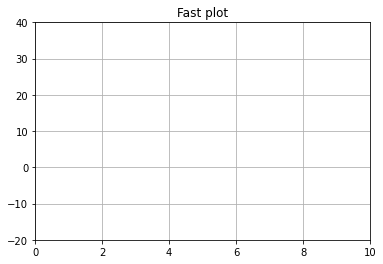

'Fast plot'

In [87]:
fast_plot(z, tw_tmp)

In [88]:
int_0_z

array([[ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [-0.025     , -0.025     ],
       ...,
       [-2.53101045, -2.53101045],
       [-2.53101045, -2.53101045],
       [-2.53101045, -2.53101045]])

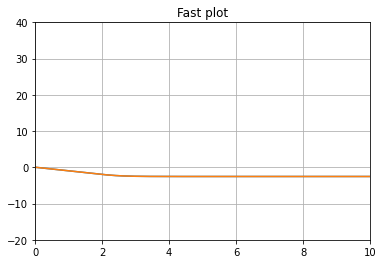

'Fast plot'

In [89]:
fast_plot(z, int_0_z)

In [90]:
int_z_infty

array([[-3.31797208, -3.31797208],
       [-3.31765958, -3.31765958],
       [-3.31672208, -3.31672208],
       ...,
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ]])

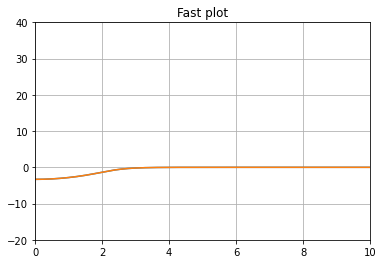

'Fast plot'

In [91]:
fast_plot(z, int_z_infty)

In [92]:
tw

array([[-1061.01045463,  1099.27060212],
       [-1061.49074208,  1098.73998124],
       [-1061.96365242,  1098.21890275],
       ...,
       [-1079.49005782,  1079.49005782],
       [-1079.49005782,  1079.49005782],
       [-1079.49005782,  1079.49005782]])

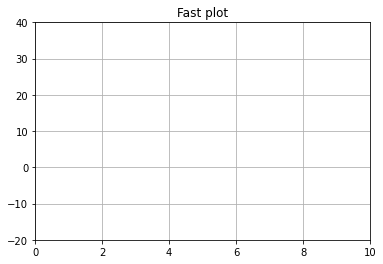

'Fast plot'

In [93]:
fast_plot(z, tw)

In [94]:
tw, _, _ = calc_tw(tw, beta_psi, rho, f1, f2, z)

/var/folders/wc/zhl433ms1fx5rvtvcrkw6dgw0000gn/T/ipykernel_95805/1870090535.py:3: RuntimeWarning: overflow encountered in exp
  hw[:, i] = np.exp(tw[:, i] - beta_phiw[:, i]) - 1.0
/var/folders/wc/zhl433ms1fx5rvtvcrkw6dgw0000gn/T/ipykernel_95805/3399659632.py:9: RuntimeWarning: invalid value encountered in multiply
  int_z_infty[k, i] = trapezoid(y=z[k:] * hw[k:, i], x=z[k:])
/var/folders/wc/zhl433ms1fx5rvtvcrkw6dgw0000gn/T/ipykernel_95805/3399659632.py:22: RuntimeWarning: invalid value encountered in multiply
  + trapezoid(y=hw[k:, j] * f1[t_minus_z, l]))
/Users/mjboothaus/code/github/mjboothaus/PhD-Thesis/.venv_phd-thesis/lib/python3.9/site-packages/numpy/lib/function_base.py:4832: RuntimeWarning: invalid value encountered in add
  ret = (d * (y[tuple(slice1)] + y[tuple(slice2)]) / 2.0).sum(axis)
/Users/mjboothaus/code/github/mjboothaus/PhD-Thesis/.venv_phd-thesis/lib/python3.9/site-packages/numpy/core/_methods.py:48: RuntimeWarning: invalid value encountered in reduce
  return umr_su

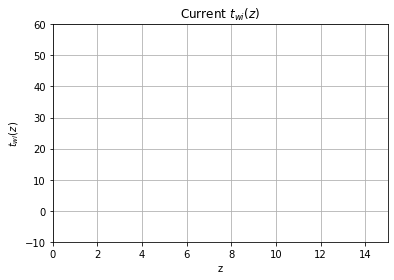

'Current $t_{wi}(z)$'

In [95]:
make_simple_plot(z, tw, "z", "$t_{wi}(z)$", "Current $t_{wi}(z)$", xliml=[0, 15], yliml=[-10, 60])

### Numerical solver: Newton-GMRES

In [96]:
# this should equal 0 (as t(z) converges to solution)

def opt_func(tw):
    return tw - calc_tw(tw, beta_psi, rho, f1, f2, z)

In [97]:
tolerance = 1e-9

In [98]:
solution = optim.root(opt_func, tw_initial, method="krylov", jac=None, tol=tolerance, callback=None, options=None)

ValueError: expected square matrix, but got shape=(12006, 4002)

In [ ]:
tw_solution = solution.x

In [ ]:
solution.nit

In [ ]:
make_simple_plot(z, tw_solution, "z", "t_{wi}(z)$", "Solution for $t_{wi}(z)$", xliml=[0, 20], yliml=[-2, 2])

In [ ]:
hw_solution = calc_hw(tw_solution, beta_phiw)

In [ ]:
make_simple_plot(z, hw_solution+1, "z", "g_{wi}(z)$", "Solution for $g_{wi}(z)$", xliml=[0, 20], yliml=[-2, 2])

In [ ]:
opt_func(tw)